In [1]:
import set_env  # not included in the repo, defines $PROJECT_DIR, $PNC_PROJECT_DIR, $IMAGEN_PROJECT_DIR & $INPUT_DIR

In [2]:
import sys
import os
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.formula.api as smf
import pickle
import statsmodels.stats.multitest
import sklearn
import pymare
from tqdm import tqdm

OUTPUT_DIR = {
    "pnc": os.path.join(os.environ["PNC_PROJECT_DIR"], "output"),
    "imagen": os.path.join(os.environ["IMAGEN_PROJECT_DIR"], "output"),
    "micamics": os.path.join(os.environ["PROJECT_DIR"], "output", "micamics")
}
INPUT_DIR = os.environ["INPUT_DIR"]
CODE_DIR = os.path.join(os.getcwd(), "..", "scripts")
sys.path.append(CODE_DIR)
from utils import transform, plot, stats, datasets
from modeling.check_fit import load_cmaes, load_cmaes_hist

import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'font.size': 16, "font.family": "Asana Math", "figure.dpi": 300})
thcolor = '#44546A'
add_text = True # add statistics as text to some figures

/data/project/ei_development/env/lib/python3.10/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


Load data of the main run and select the 200 subsample subjects:

In [3]:
elig_subs = pd.read_csv(
    os.path.join(INPUT_DIR, "pnc_subs.csv"), index_col=0
).sort_index()
parcels = transform.load_ordered_parcel_labels('schaefer-100')

if os.path.exists('pnc_optima.csv') & os.path.exists('pnc_vars.pkz'):
    subjects_optima = pd.read_csv('pnc_optima.csv', index_col=0)
    with open('pnc_vars.pkz', 'rb') as f:
        regional_vars = pickle.load(f)
else:
    raise FileNotFoundError("Run Figure 2 first")

# limit the optima to subsample
subsample = np.loadtxt(os.path.join(INPUT_DIR, 'pnc_subsample_200.txt'), dtype=str)
subjects_optima = subjects_optima.loc[subjects_optima['sub'].isin(subsample)]

# select optimal runs and add demographics
best_runs = subjects_optima.groupby("sub")["gof"].idxmax().values
data = subjects_optima.loc[best_runs].set_index("sub")
data[["age", "sex"]] = elig_subs.loc[data.index, ["age", "sex"]]
data["Age (y)"] = data["age"] / 12

# load I_E of optimal runs
I_E = pd.DataFrame(index=data.index, columns=parcels, dtype=float)
for i, parc in enumerate(parcels):
    for sub, row in data.iterrows():
        I_E.loc[sub, parc] = regional_vars[sub][row['SeedMW']].loc[i, 'I_E']

Split data into two age groups for comparing ICCs between them:

In [4]:
data_by_age = {
    'younger': data.loc[data['age']<data['age'].median()],
    'older': data.loc[data['age']>=data['age'].median()]
}

# Figure S14. Effect of conduction delay on goodness-of-fit and E-I ratio

Load data:

In [5]:
all_v_IE = {}
all_v_fits = {}
vlist = ['v-orig_dt-0.1', 'v-orig_dt-1.0', 'v-1', 'v-2', 'v-3', 'v-4', 'v-5', 'v-6']

for v in vlist:
    all_v_IE[v] = pd.DataFrame(index=data.index, columns=parcels)
    all_v_fits[v] = {}
    for sub, row in tqdm(data.iterrows()):
        cmaes_log_path = os.path.join(
            OUTPUT_DIR['pnc'], 'sim', sub, 
            'ctx_parc-schaefer-100_mean001_thresh-1',
            '6maps_schaefer-100_zscore', 'cmaes_multimaps_gpu',
            f'ctx_parc-schaefer-100_hemi-LR_highpass-013_lowpass'\
            f'-none_exc-inter_G_0.5-4_wee_0.05-0.75_wei_0.05-0.75_wie_0_'\
            f'het-wee-wei_SeedMW-{row["SeedMW"]}_SeedSim-410_n-81x210.txt')
        base_dir = cmaes_log_path.replace('.txt', '_cubnm')
        if not os.path.exists(base_dir):
            print(sub, "not found")
            continue
        try:
            sim_data = np.load(os.path.join(base_dir, v, 'it1.npz'), allow_pickle=True)
        except FileNotFoundError:
            print(sub, "not found")
            continue
        all_v_IE[v].loc[sub, :] = sim_data['sim_states'].flatten()[0]['I_E'].squeeze()
        all_v_fits[v][sub] = pd.read_csv(os.path.join(base_dir, v, 'score.csv'), index_col=0).T.iloc[:, 0]
    all_v_fits[v] = pd.DataFrame(all_v_fits[v]).T
    # make the cubnm gof measures comparable to the main results (without -/+ signs)
    all_v_fits[v][['-fc_diff', '-fcd_ks']] = -all_v_fits[v][['-fc_diff', '-fcd_ks']]
    all_v_fits[v].columns = [s.replace('-','').replace('+','') for s in all_v_fits[v].columns]

200it [00:02, 71.16it/s]
200it [00:01, 110.02it/s]
200it [00:01, 110.04it/s]
200it [00:01, 104.82it/s]
200it [00:01, 102.93it/s]
200it [00:01, 110.11it/s]
200it [00:01, 101.44it/s]
200it [00:01, 105.14it/s]


## A. Goodness-of-fit comparison

In [6]:
gof_labels = {
    'gof': 'Goodness of fit',
    'fc_corr': 'FC correlation',
    'fc_diff': 'FC difference',
    'fcd_ks': 'FCD KS distance',
}

gof v-1 -0.13263895967884506 0.8946129406281045 -0.0004511791643930146 0.0481052998975329
gof v-2 2.50874382321947 0.012914317324970979 0.004222278381636315 0.02380156672896939
gof v-3 3.044288491706942 0.0026475505682130164 0.0031000121060003796 0.014400997723341096
gof v-4 3.0480859167589514 0.002615811698366441 0.002116023254533816 0.009817665468040783
gof v-5 3.2612760693338423 0.001304926980974031 0.0016725747145615066 0.0072529212342895884
gof v-6 3.574623512326994 0.00044015255700913513 0.0014730415352887719 0.0058277334940600705
fc_corr v-1 1.824519119564511 0.06957320096836317 0.0005458509556960981 0.004230976898526511
fc_corr v-2 3.2025386904369793 0.0015861889238227463 0.0004642907317230205 0.0020502679691193097
fc_corr v-3 2.058353807278569 0.040859158557631 0.00019689153343983732 0.0013527639219381776
fc_corr v-4 1.3038573654173589 0.19378846183155965 9.238308468803344e-05 0.0010020222668900506
fc_corr v-5 0.6502558126993997 0.5162769827071357 3.501740072299087e-05 0.00076

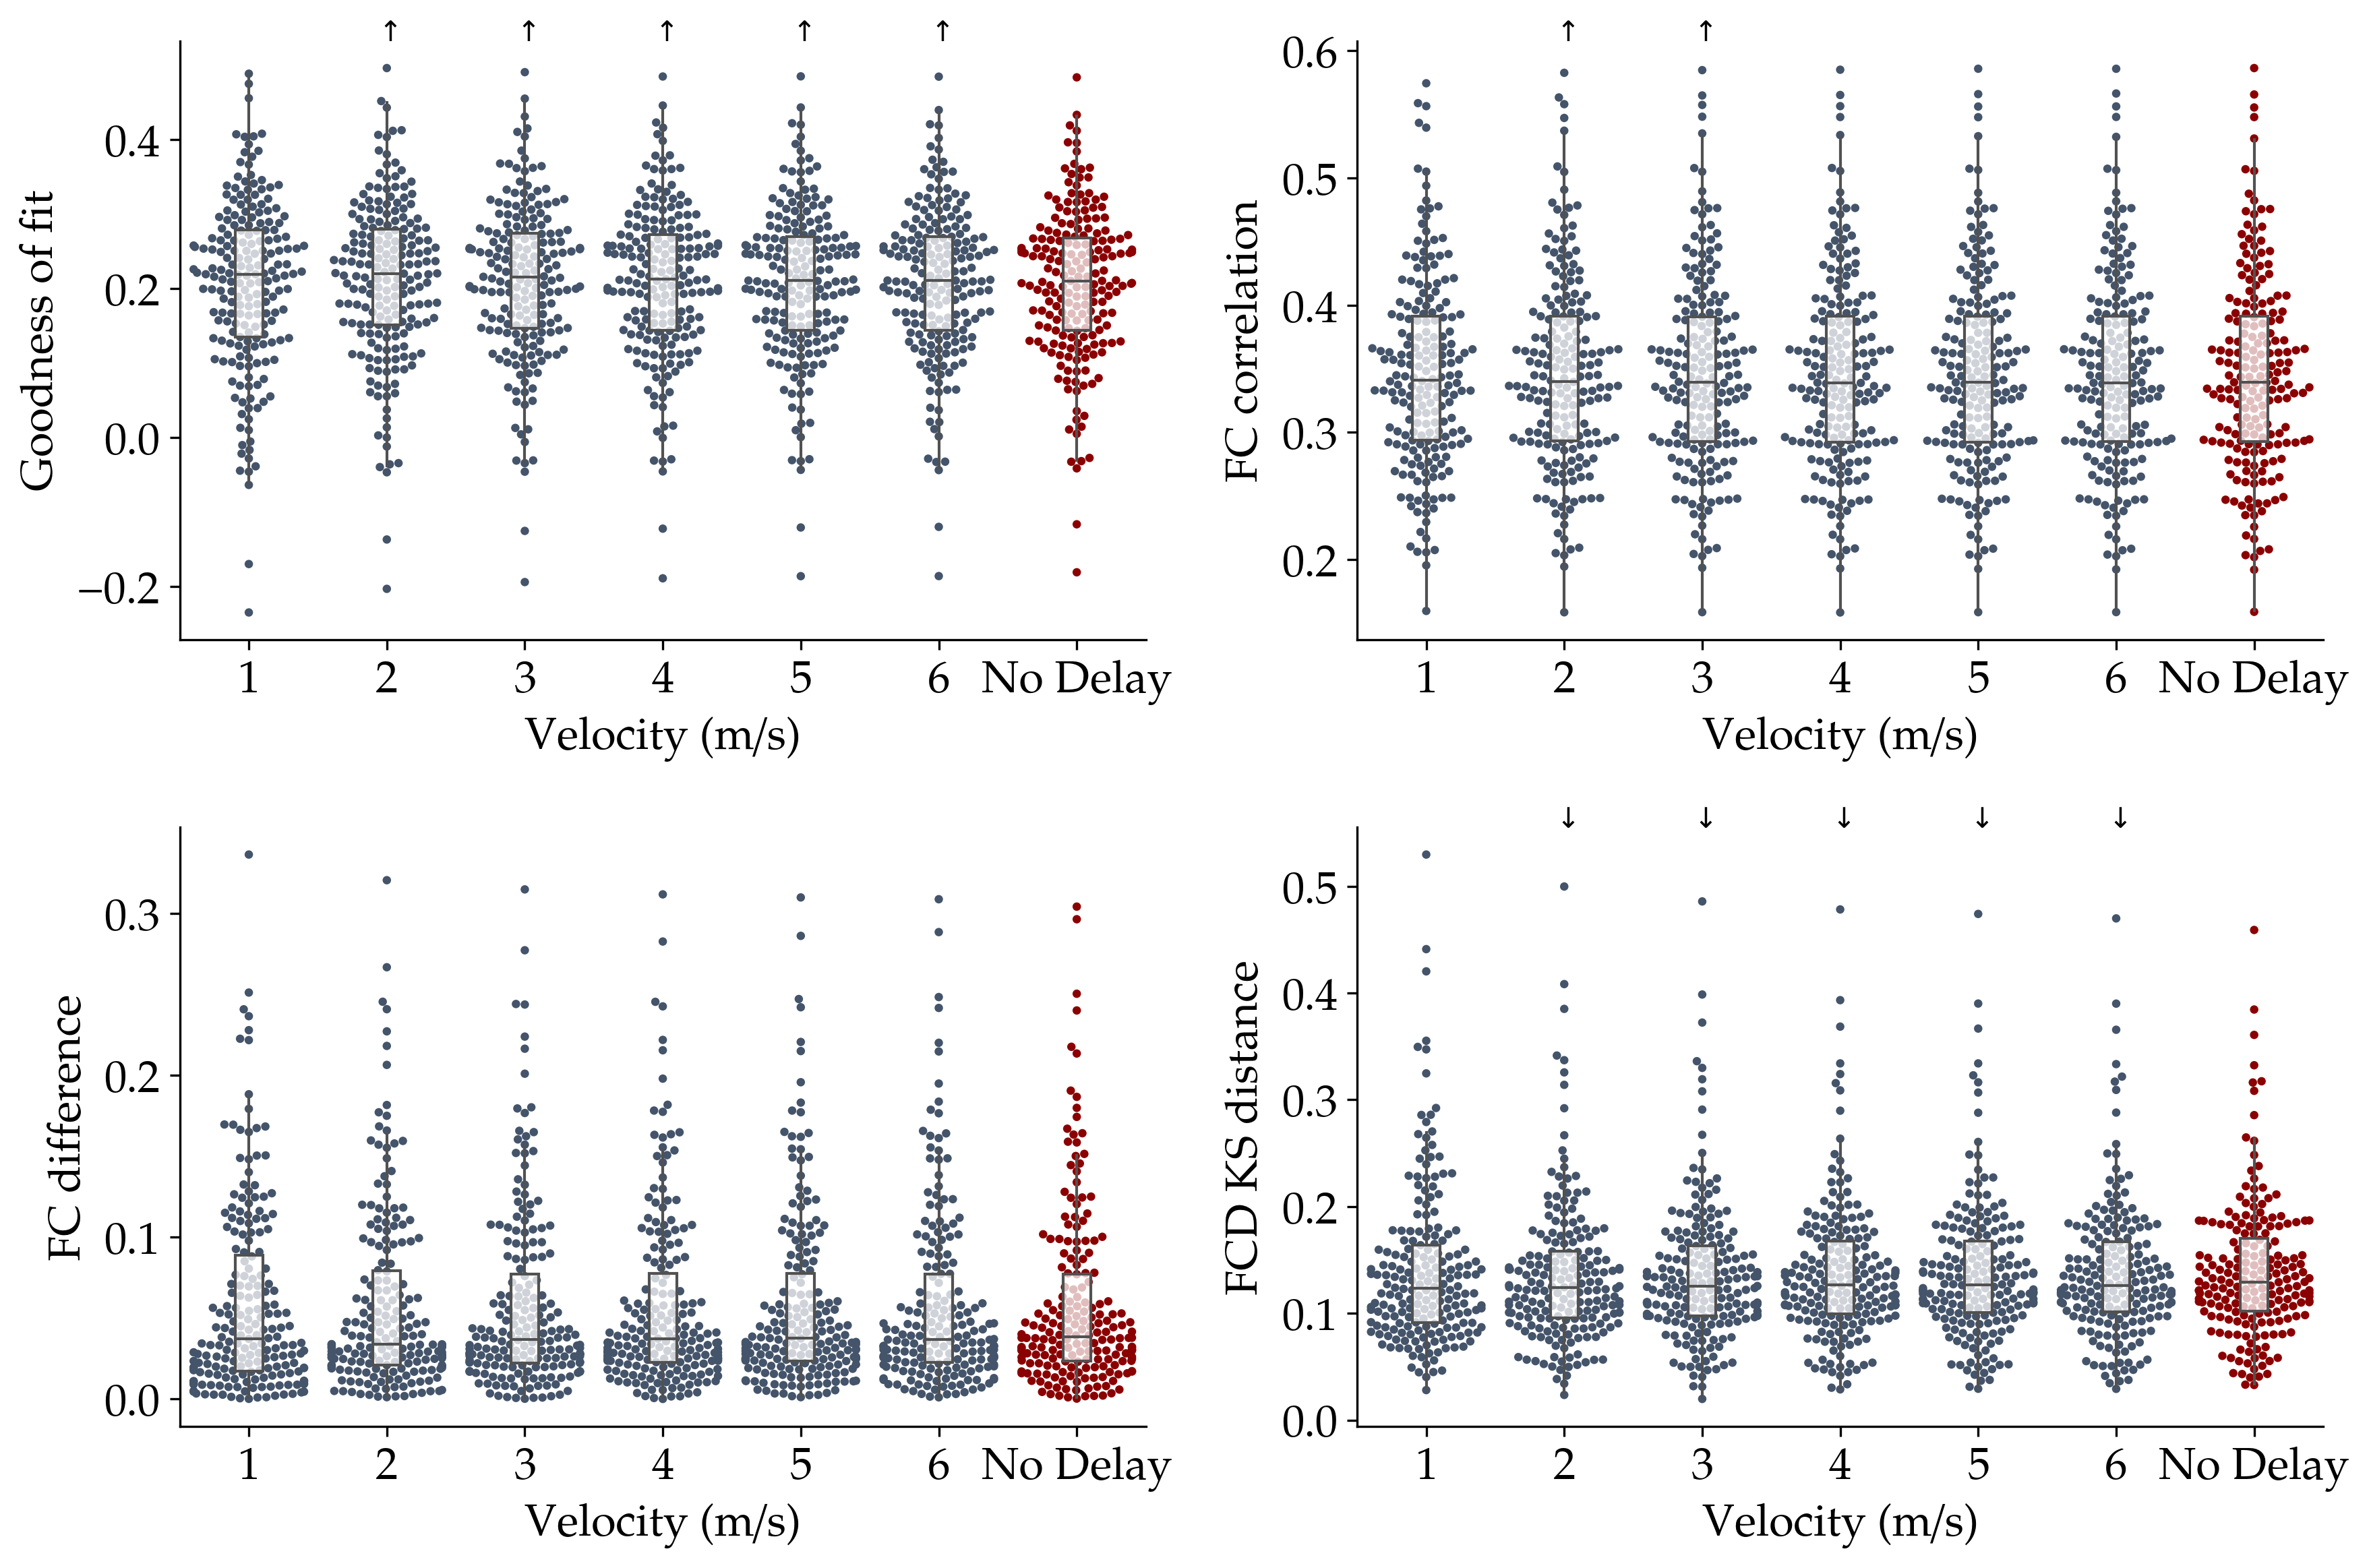

In [7]:
# exclude dt-0.1 and sort the velocities >0
vlist_ordered = vlist[1:2] + vlist[-1:1:-1]
vlist_ordered = vlist_ordered[::-1]
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
for i, (col, label) in enumerate(gof_labels.items()):
    ax = axes[i]
    plot_data = {}
    for v in vlist_ordered:
        plot_data[v] = all_v_fits[v].loc[:, col]
    plot_data = pd.DataFrame(plot_data).unstack().reset_index()
    sns.swarmplot(
        data=plot_data,
        x='level_0', y=0,
        s=3, palette=[thcolor]*(len(vlist_ordered)-1)+['darkred'],
        ax=ax
    )
    sns.boxplot(
        data=plot_data,
        x='level_0', y=0,
        showfliers=False,
        showcaps=False, width=0.2,
        boxprops={"facecolor": (1, 1, 1, 0.75)},
        ax=ax)
    plt.setp(ax.collections, zorder=0, label="") # puts swarm in the back
    ax.set_ylabel(label)
    ax.set_xticklabels(list(range(1, 7)) + ['No Delay'])
    ax.set_xlabel('Velocity (m/s)')
    sns.despine()
    # print statistics and add significant increase/decrease indicator
    for j, v in enumerate(vlist_ordered[:-1]):
        t, p = scipy.stats.ttest_rel(all_v_fits[v].loc[:, col], all_v_fits['v-orig_dt-1.0'].loc[:, col])
        if p < 0.05:
            text_x = j-0.10
            text_y = ax.get_ylim()[1]
            if t < 0:
                text = r'$\downarrow$'
            else:
                text = r'$\uparrow$'
            # text = '*'
            ax.text(text_x, text_y, text, fontsize=10, multialignment='center')
        diff = (all_v_fits[v].loc[:, col] - all_v_fits['v-orig_dt-1.0'].loc[:, col])
        print(col, v, t, p, diff.mean(), diff.std())
fig.tight_layout(pad=1.0)

## B. Node-level intraclass correlation of E-I ratio

In [8]:
icc_v = pd.DataFrame(index=parcels, columns=vlist_ordered[:-1], dtype=float)
for v in tqdm(vlist_ordered[:-1]):
    for i, parc in enumerate(parcels):
        icc_df = pd.DataFrame(index=data.index, dtype=float)
        for sub in data.index:
            icc_df.loc[sub, 'orig'] = all_v_IE['v-orig_dt-1.0'].loc[sub, parc]
            icc_df.loc[sub, v] = all_v_IE[v].loc[sub, parc]
        icc_v.loc[parc, v] = stats.madicc(icc_df.loc[:, 'orig'], icc_df.loc[:, v])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:18<00:00,  3.16s/it]


In [9]:
icc_v.describe().round(3)

v-1      v-2      v-3      v-4      v-5      v-6
count  100.000  100.000  100.000  100.000  100.000  100.000
mean     0.977    0.989    0.993    0.995    0.997    0.997
std      0.017    0.008    0.005    0.004    0.003    0.002
min      0.908    0.963    0.966    0.979    0.980    0.987
25%      0.970    0.988    0.991    0.993    0.996    0.997
50%      0.983    0.991    0.995    0.996    0.997    0.998
75%      0.988    0.995    0.997    0.998    0.999    0.999
max      0.998    0.999    1.000    1.000    1.000    1.000

Comparison of ICC between younger and older age groups:

In [10]:
icc_v_by_age = {
    'younger': pd.DataFrame(index=parcels, columns=vlist_ordered[:-1], dtype=float),
    'older': pd.DataFrame(index=parcels, columns=vlist_ordered[:-1], dtype=float)
}
for v in tqdm(vlist_ordered[:-1]):
    for i, parc in enumerate(parcels):
        icc_df = pd.DataFrame(index=data.index, dtype=float)
        for sub in data.index:
            icc_df.loc[sub, 'orig'] = all_v_IE['v-orig_dt-1.0'].loc[sub, parc]
            icc_df.loc[sub, v] = all_v_IE[v].loc[sub, parc]
        for age in data_by_age.keys():
            subs = data_by_age[age].index
            icc_v_by_age[age].loc[parc, v] = stats.madicc(icc_df.loc[subs, 'orig'], icc_df.loc[subs, v])
    print(v, scipy.stats.ttest_rel(icc_v_by_age['younger'][v], icc_v_by_age['older'][v]))

 17%|███████████████████████████▌                                                                                                                                         | 1/6 [00:03<00:17,  3.49s/it]

v-1 TtestResult(statistic=1.2725077584194517, pvalue=0.20617331480844203, df=99)


 33%|███████████████████████████████████████████████████████                                                                                                              | 2/6 [00:07<00:14,  3.53s/it]

v-2 TtestResult(statistic=1.447981785729201, pvalue=0.15078173978563392, df=99)


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 3/6 [00:10<00:10,  3.52s/it]

v-3 TtestResult(statistic=0.40211467879639334, pvalue=0.6884664783635475, df=99)


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 4/6 [00:14<00:07,  3.54s/it]

v-4 TtestResult(statistic=0.01829840758047946, pvalue=0.9854376255661634, df=99)


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 5/6 [00:17<00:03,  3.53s/it]

v-5 TtestResult(statistic=-0.8835628360723348, pvalue=0.3790728792316437, df=99)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:21<00:00,  3.53s/it]

v-6 TtestResult(statistic=0.10467091542689123, pvalue=0.9168487112751641, df=99)


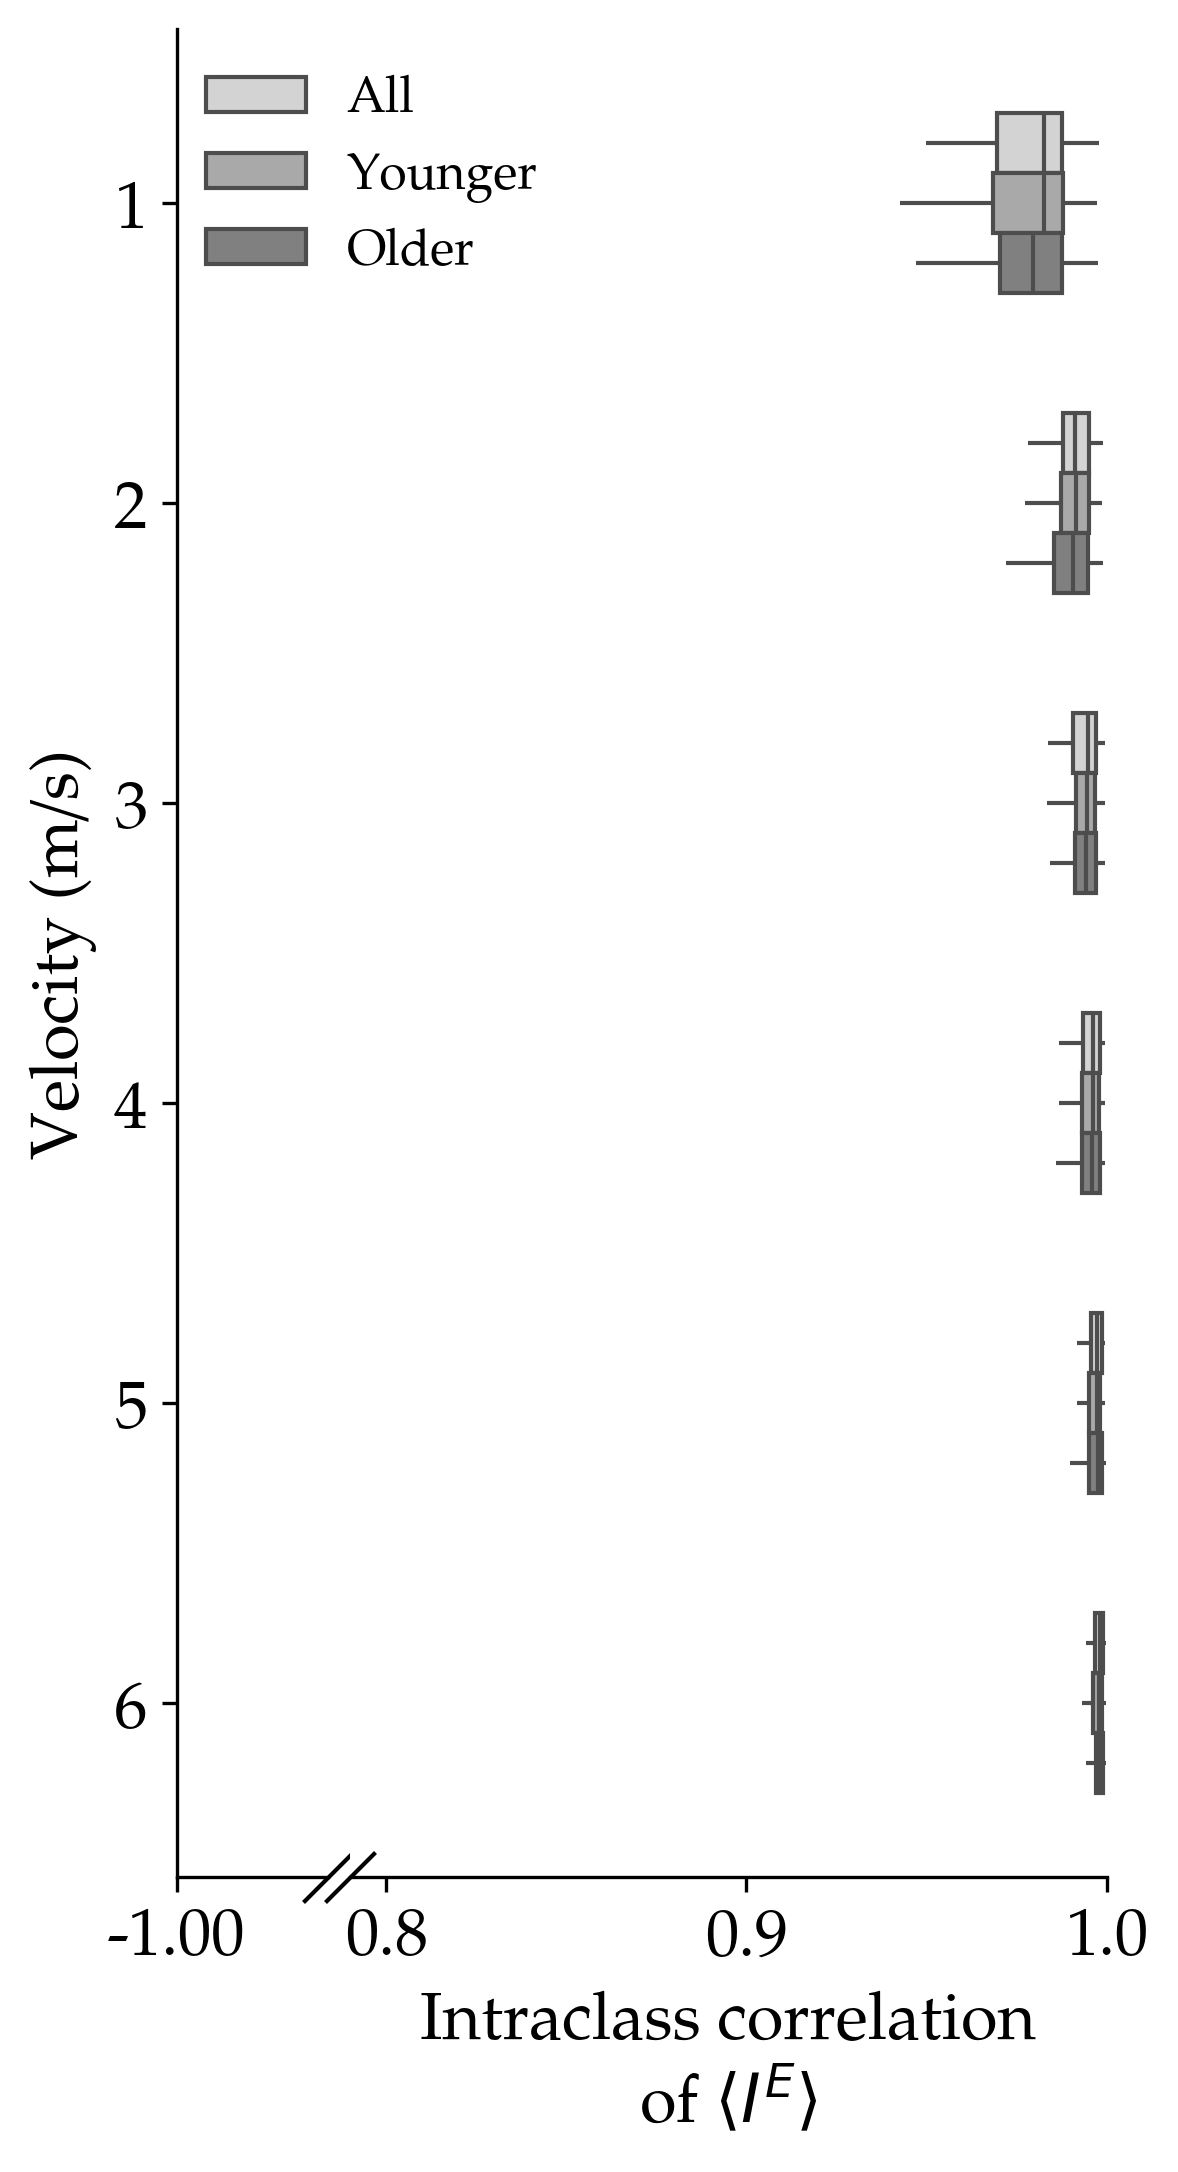

In [11]:
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(4, 8), sharex=False, gridspec_kw={'width_ratios': [1, 5], 'wspace': 0.05})

plot_data = []

long_df = icc_v.unstack().reset_index()
long_df['group'] = 'All'
plot_data.append(long_df)
for age in icc_v_by_age.keys():
    long_df = icc_v_by_age[age].unstack().reset_index()
    long_df['group'] = age.title()
    plot_data.append(long_df)

plot_data = pd.concat(plot_data, axis=0)

# dummy boxplot for the broken axis starting from -1
sns.boxplot(
    data=plot_data,
    y='level_0',
    hue='group',
    x=0,
    showfliers=False,
    showcaps=False, width=0.6,
    palette=['lightgrey', 'darkgrey', 'grey'],
    ax=ax2,
    legend=False
)
ax2.set_xlim(-1, -0.92)
ax2.set_xticks([-1.0], labels=['-1.00'])
ax2.set_yticklabels(list(range(1, 7)))
ax2.set_ylabel('Velocity (m/s)')
ax2.set_xlabel('')
sns.despine(ax=ax2)

sns.boxplot(
    data=plot_data,
    y='level_0',
    hue='group',
    x=0,
    showfliers=False,
    showcaps=False, width=0.6,
    palette=['lightgrey', 'darkgrey', 'grey'],
    ax=ax1,
    legend=True
)

ax1.legend(loc='upper left', fontsize=12, frameon=False, bbox_to_anchor=(-0.25, 1.0))
ax1.set_xlim(0.79, 1)
ax1.set_xlabel('Intraclass correlation\n'
               r'of $\langle I^E \rangle$')
ax1.set_yticks([])
ax1.set_ylabel('')
sns.despine(ax=ax1, left=True)

d = 1  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax2.plot([1], [0], transform=ax2.transAxes, **kwargs)
ax1.plot([0], [0], transform=ax1.transAxes, **kwargs)


# since none of the p-values are significant, will not implement the significance indicator

# Figure S15. Effect of optimization seeds on goodness-of-fit and E-I ratio

## A. Goodness-of-fit comparison

Goodness of fit	0.246	0.806	0.0	0.01
FC correlation	0.327	0.744	0.0	0.01
FC difference	1.984	0.049	0.001	0.009
FCD KS distance	-2.035	0.043	-0.001	0.008


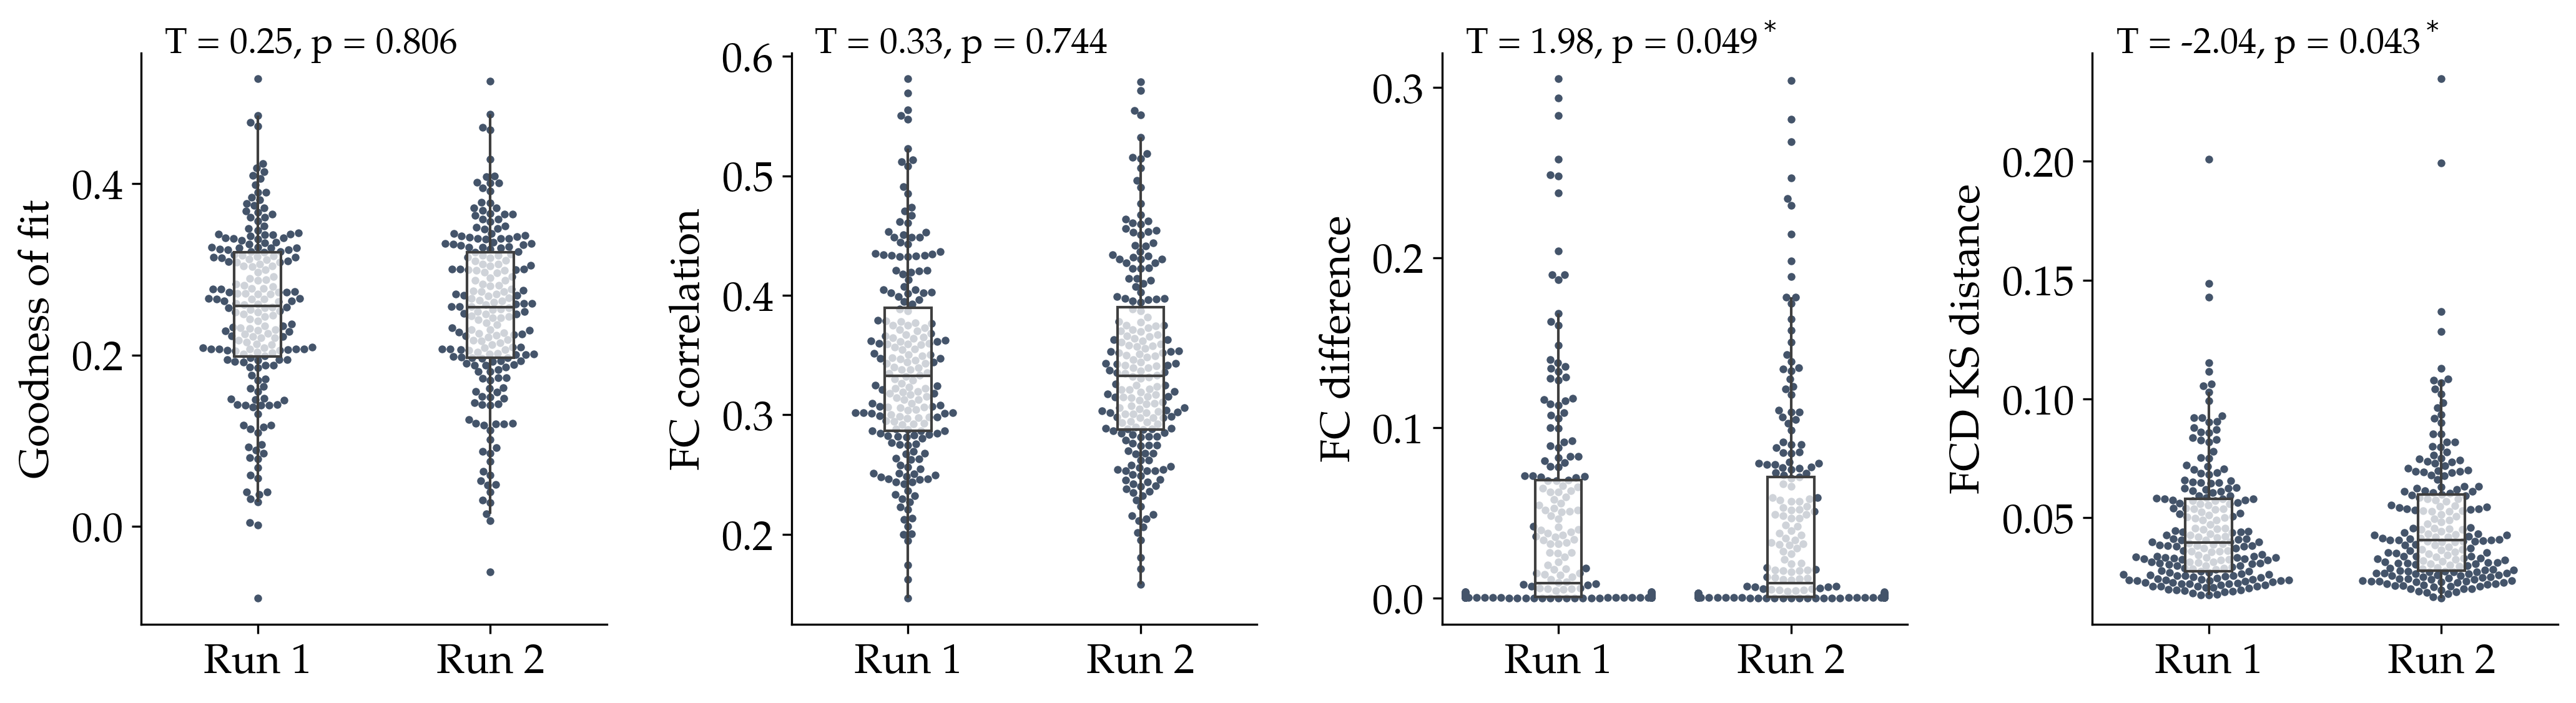

In [12]:
fig, axes = plt.subplots(1, len(gof_labels), figsize=(14, 4))
for i, (col, label) in enumerate(gof_labels.items()):
    ax = axes[i]
    sns.swarmplot(
        data=subjects_optima,
        x='SeedMW', y=col,
        s=3, color=thcolor,
        ax=ax
    )
    sns.boxplot(
        data=subjects_optima,
        x='SeedMW', y=col,
        showfliers=False,
        showcaps=False, width=0.2,
        boxprops={"facecolor": (1, 1, 1, 0.75)},
        ax=ax)
    plt.setp(ax.collections, zorder=0, label="") # puts swarm in the back
    ax.set_ylabel(label)
    ax.set_xticklabels(['Run 1', 'Run 2'])
    ax.set_xlabel('')
    sns.despine()
    # add statistics
    t, p = scipy.stats.ttest_rel(
        subjects_optima.loc[subjects_optima['SeedMW']==1, col], 
        subjects_optima.loc[subjects_optima['SeedMW']==2, col]
    )
    mean_diff = (
        subjects_optima.loc[subjects_optima['SeedMW']==1, col].values - 
        subjects_optima.loc[subjects_optima['SeedMW']==2, col].values
    ).mean()
    sd_diff = (
        subjects_optima.loc[subjects_optima['SeedMW']==1, col].values - 
        subjects_optima.loc[subjects_optima['SeedMW']==2, col].values
    ).std()    
    if add_text:
        if p > 0.001:
            text = f'T = {t:.2f}, p = {p:.3f}'
        else:
            text = f'T = {t:.2f}, p < 0.001'
        if p < 0.05:
            text+=r'$^*$'
        text_x = ax.get_xlim()[0]+(ax.get_xlim()[1]-ax.get_xlim()[0])*0.05
        text_y = ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*1
        ax.text(text_x, text_y, 
                text,
                color='black',
                size=14,
                multialignment='left')
    print(label, round(t, 3), round(p,3), round(mean_diff,3), round(sd_diff,3), sep="\t")
fig.tight_layout(pad=1.0)

## B. Node-level intraclass correlation of E-I ratio

In [16]:
icc_opt = pd.Series(index=parcels, dtype=float)
for i, parc in enumerate(parcels):
    icc_df = pd.DataFrame(index=data.index, columns=[1, 2], dtype=float)
    for sub in data.index:
        for SeedMW in [1, 2]:
            icc_df.loc[sub, SeedMW] = regional_vars[sub][SeedMW].loc[i, 'I_E']
    icc_opt.loc[parc] = stats.madicc(icc_df.iloc[:, 0], icc_df.iloc[:, 1])

In [22]:
icc_opt_by_age = pd.DataFrame(index=parcels, dtype=float)
for age in data_by_age.keys():
    for i, parc in enumerate(parcels):
        icc_df = pd.DataFrame(index=data_by_age[age].index, columns=[1, 2], dtype=float)
        for sub in data_by_age[age].index:
            for SeedMW in [1, 2]:
                icc_df.loc[sub, SeedMW] = regional_vars[sub][SeedMW].loc[i, 'I_E']
        icc_opt_by_age.loc[parc, age] = stats.madicc(icc_df.iloc[:, 0], icc_df.iloc[:, 1])
icc_opt_by_age['all'] = icc_opt

       younger    older      all
count  100.000  100.000  100.000
mean     0.943    0.941    0.946
std      0.030    0.026    0.021
min      0.839    0.864    0.874
25%      0.927    0.922    0.934
50%      0.948    0.946    0.950
75%      0.966    0.960    0.961
max      0.987    0.985    0.982
T =0.5575935796150813, p = 0.5783805761507439


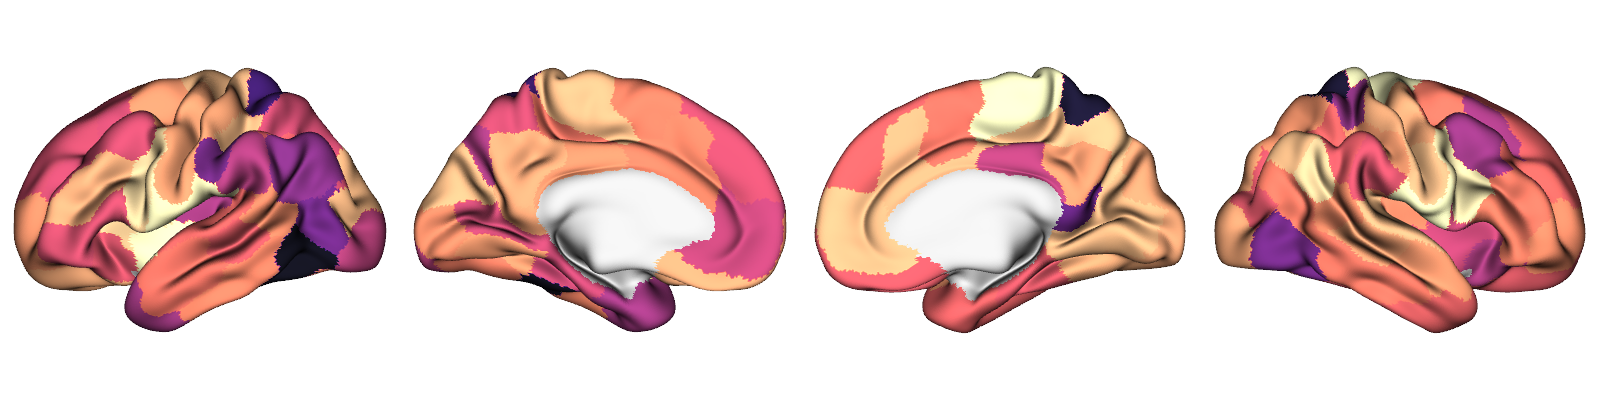

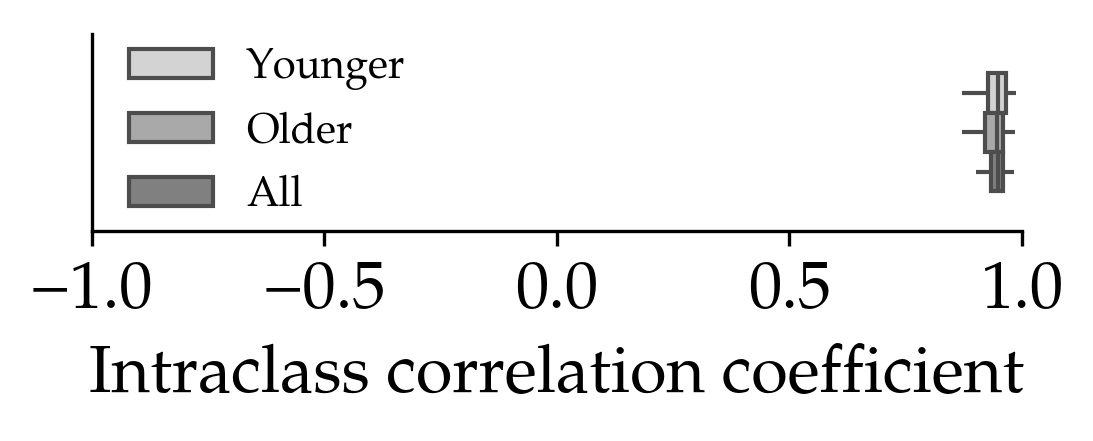

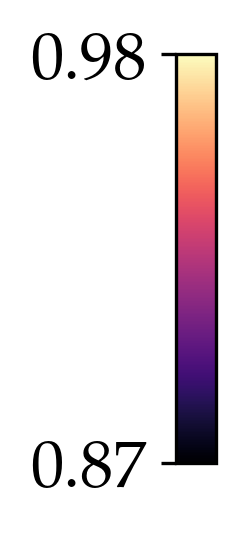

In [23]:
print(icc_opt_by_age.describe().round(3))
plot.plot_icc_by_age(icc_opt_by_age, 'schaefer-100')

# Figure S16. Effect of Gaussian noise random seed on goodness-of-fit and E-I ratio

Load the simulation data of alternative seeds:

In [24]:
orig_seed = 410
alt_seeds = list(range(50))

all_seed_IE = {}
all_seed_fits = {}
for rand_seed in [orig_seed]+alt_seeds:
    base_dir = os.path.join('./sim_seed', f'SeedSim-{rand_seed}')
    sim_states = np.load(os.path.join(base_dir, 'states.npz'))
    all_seed_IE[rand_seed] = pd.DataFrame(sim_states['I_E'], index=data.index, columns=parcels)
    scores = pd.read_csv(os.path.join(base_dir, 'scores.csv'), index_col=0)
    # make the cubnm gof measures comparable to the main results (without -/+ signs)
    scores[['-fc_diff', '-fcd_ks']] = -scores[['-fc_diff', '-fcd_ks']]
    scores.columns = [s.replace('-','').replace('+','') for s in scores.columns]
    all_seed_fits[rand_seed] = scores

## A. Goodness-of-fit comparison

Calculate the median of their GOF measures:

In [25]:
orig_fits = all_seed_fits[orig_seed]
median_fits = {}
for sub in data.index:
    sub_fits = {}
    for seed in alt_seeds:
        sub_fits[seed] = all_seed_fits[seed].loc[sub]
    median_fits[sub] = pd.DataFrame(sub_fits).median(axis=1)
median_fits = pd.DataFrame(median_fits).T

Compare GOF of original seed and alternative seeds:

Goodness of fit	31.064	0.0	0.101	0.046
FC correlation	8.946	0.0	0.011	0.018
FC difference	-7.272	0.0	-0.009	0.018
FCD KS distance	-26.615	0.0	-0.078	0.042


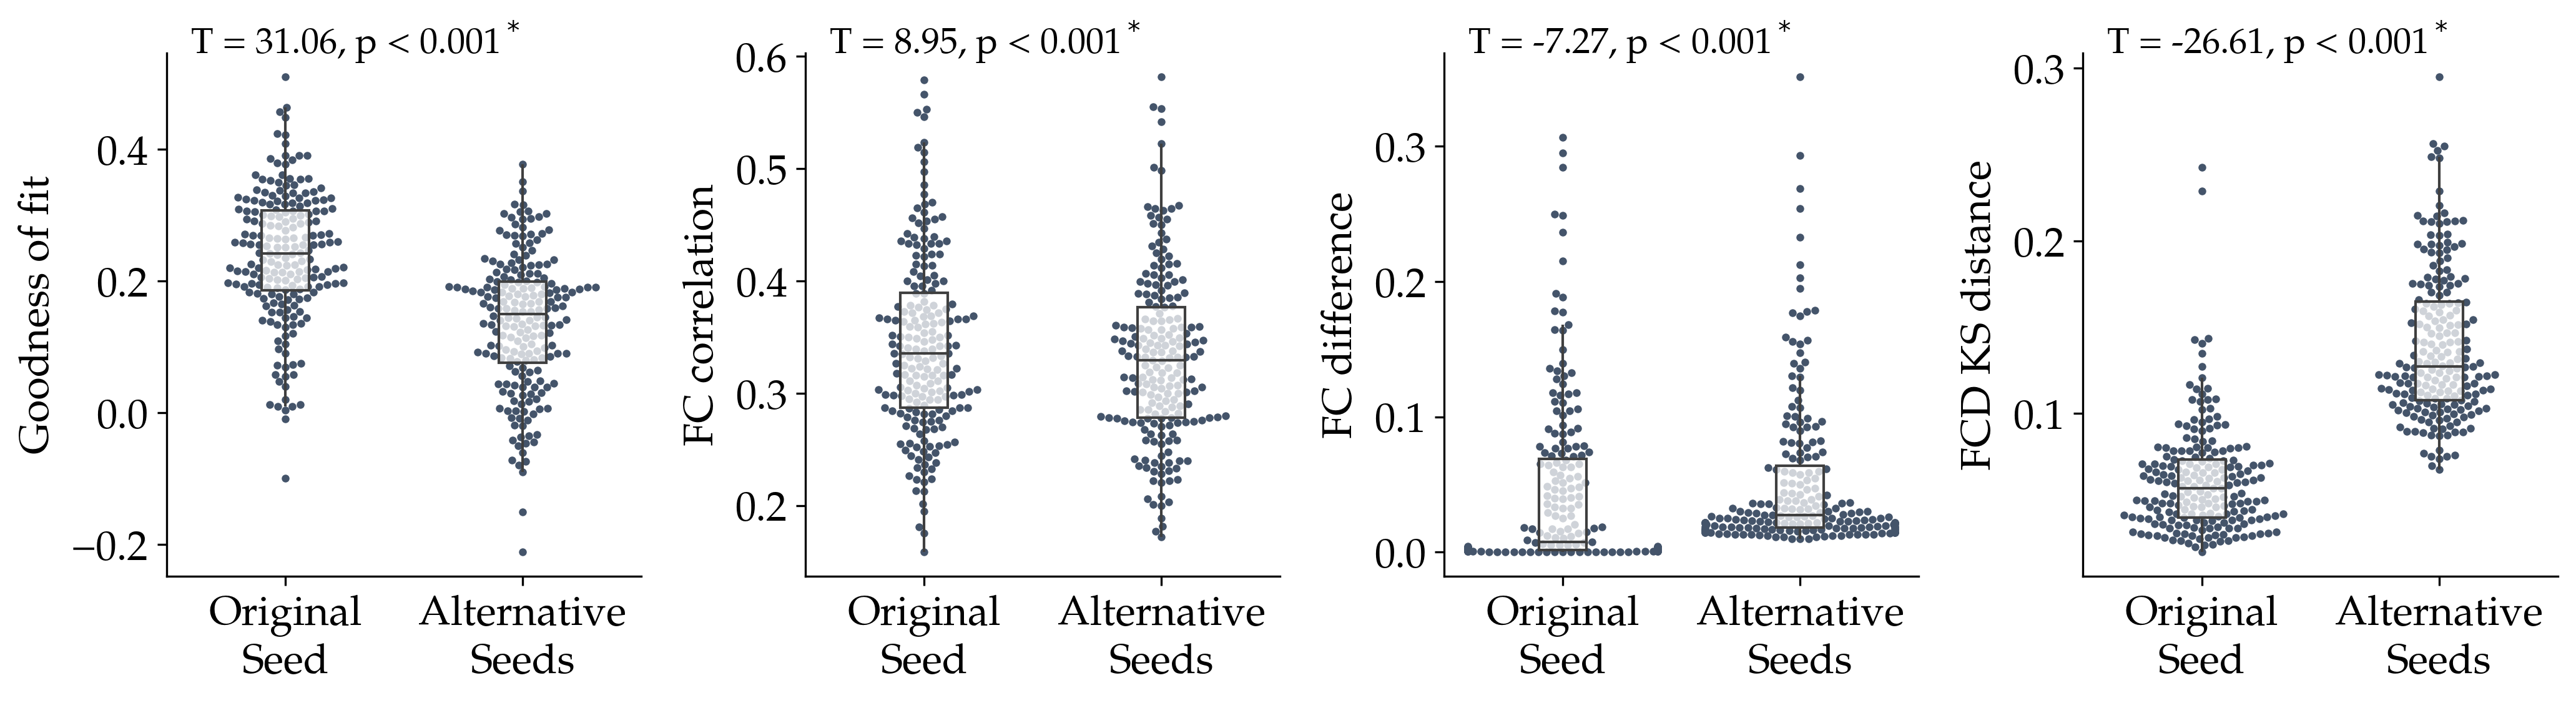

In [26]:
fig, axes = plt.subplots(1, len(gof_labels), figsize=(14, 4))
for i, (col, label) in enumerate(gof_labels.items()):
    ax = axes[i]
    plot_data = pd.DataFrame({'orig': orig_fits[col], 'alt': median_fits[col]}).unstack().reset_index()
    sns.swarmplot(
        data=plot_data,
        x='level_0', y=0,
        s=3, color=thcolor,
        ax=ax
    )
    sns.boxplot(
        data=plot_data,
        x='level_0', y=0,
        showfliers=False,
        showcaps=False, width=0.2,
        boxprops={"facecolor": (1, 1, 1, 0.75)},
        ax=ax)
    plt.setp(ax.collections, zorder=0, label="") # puts swarm in the back
    ax.set_ylabel(label)
    ax.set_xticklabels(['Original\nSeed', 'Alternative\nSeeds'])
    ax.set_xlabel('')
    sns.despine()
    # add statistics
    t, p = scipy.stats.ttest_rel(orig_fits[col], median_fits[col])
    mean_diff = (orig_fits[col] - median_fits[col]).mean()
    sd_diff = (orig_fits[col] - median_fits[col]).std()
    if add_text:
        if p > 0.001:
            text = f'T = {t:.2f}, p = {p:.3f}'
        else:
            text = f'T = {t:.2f}, p < 0.001'
        if p < 0.05:
            text+=r'$^*$'
        text_x = ax.get_xlim()[0]+(ax.get_xlim()[1]-ax.get_xlim()[0])*0.05
        text_y = ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*1
        ax.text(text_x, text_y, 
                text,
                color='black',
                size=14,
                multialignment='left')
    print(label, round(t, 3), round(p,3), round(mean_diff, 3), round(sd_diff, 3), sep="\t")
fig.tight_layout(pad=1.0)

## B. Node-level intraclass correlation of E-I ratio

In [27]:
icc_seed = pd.DataFrame(index=parcels, columns=range(50), dtype=float)
for rand_seed in tqdm(range(50)):
    for i, parc in enumerate(parcels):
        icc_df = pd.DataFrame(
            {'orig': all_seed_IE[orig_seed].iloc[:, i], rand_seed: all_seed_IE[rand_seed].iloc[:, i]},
            index=data.index, dtype=float
        )
        icc_seed.loc[parc, rand_seed] = stats.madicc(icc_df.loc[:, 'orig'], icc_df.loc[:, rand_seed])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.19it/s]


In [28]:
icc_seed.describe()

0           1           2           3           4           5   \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     0.784264    0.794385    0.769631    0.777404    0.775078    0.711870   
std      0.164396    0.177799    0.178319    0.173264    0.192499    0.261602   
min      0.136539   -0.016353    0.025311   -0.257562   -0.317577   -0.368738   
25%      0.734250    0.716744    0.693706    0.719341    0.733717    0.684029   
50%      0.840305    0.860392    0.831758    0.809860    0.832847    0.786709   
75%      0.897008    0.905346    0.892954    0.904311    0.893097    0.870771   
max      0.973378    0.977682    0.977519    0.973548    0.956044    0.955246   

               6           7           8           9   ...          40  \
count  100.000000  100.000000  100.000000  100.000000  ...  100.000000   
mean     0.793264    0.781256    0.706445    0.789341  ...    0.759860   
std      0.194016    0.177168    0.275782    0.166869  ...    0.201219   
min     -0.228397    0.027867   -0.447385    0.036415  ...   -0.125790   
25%      0.762565    0.765299    0.665107    0.749281  ...    0.698405   
50%      0.844855    0.834108    0.799856    0.826324  ...    0.818582   
75%      0.913237    0.884454    0.865569    0.900405  ...    0.887794   
max      0.977766    0.957184    0.966089    0.969887  ...    0.980751   

               41          42          43          44          45          46  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     0.758791    0.789941    0.737971    0.819788    0.805344    0.747840   
std      0.214007    0.174901    0.213807    0.151227    0.154012    0.236127   
min     -0.187632    0.181162   -0.085031    0.308598    0.279834   -0.316316   
25%      0.712034    0.754764    0.691339    0.771986    0.763357    0.690435   
50%      0.830061    0.843526    0.803354    0.872364    0.850365    0.814018   
75%      0.898969    0.900332    0.869858    0.926978    0.908803    0.898200   
max      0.962896    0.967407    0.959632    0.978639    0.972521    0.964847   

               47          48          49  
count  100.000000  100.000000  100.000000  
mean     0.753063    0.739244    0.784236  
std      0.160204    0.198374    0.177059  
min      0.046292   -0.209081    0.044760  
25%      0.700309    0.686860    0.739407  
50%      0.806824    0.802774    0.837456  
75%      0.859145    0.870510    0.906224  
max      0.934879    0.978531    0.975022  

[8 rows x 50 columns]

Take median across 50 random seeds

In [29]:
icc_seed_median = icc_seed.median(axis=1)

Comparison of ICC between younger and older age groups:

In [30]:
# calculate ICC by age in each alternative seed vs original seeds
icc_seed_by_age = {
    'younger': pd.DataFrame(index=parcels, columns=range(50), dtype=float),
    'older': pd.DataFrame(index=parcels, columns=range(50), dtype=float)
}
for rand_seed in tqdm(range(50)):
    for i, parc in enumerate(parcels):
        icc_df = pd.DataFrame(
            {'orig': all_seed_IE[orig_seed].iloc[:, i], rand_seed: all_seed_IE[rand_seed].iloc[:, i]},
            index=data.index, dtype=float
        )
        for age in data_by_age.keys():
            subs = data_by_age[age].index
            icc_seed_by_age[age].loc[parc, rand_seed] = stats.madicc(icc_df.loc[subs, 'orig'], icc_df.loc[subs, rand_seed])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.34it/s]


       younger    older      all
count  100.000  100.000  100.000
mean     0.804    0.801    0.810
std      0.115    0.097    0.100
min      0.323    0.412    0.368
25%      0.785    0.764    0.787
50%      0.835    0.826    0.839
75%      0.863    0.864    0.869
max      0.948    0.941    0.929
T =0.3005568688758825, p = 0.7643826865229977


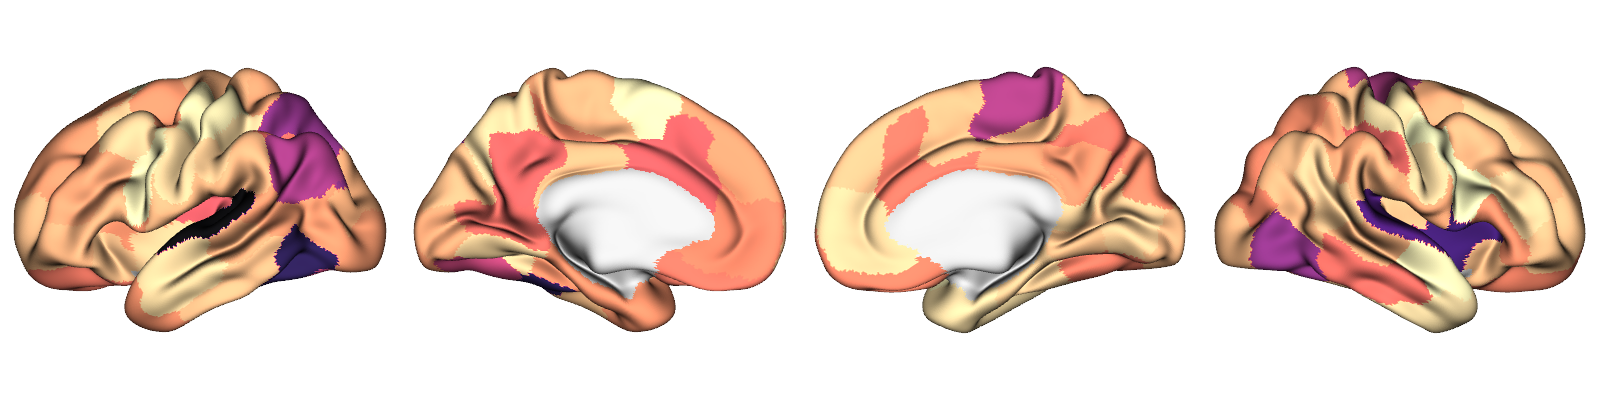

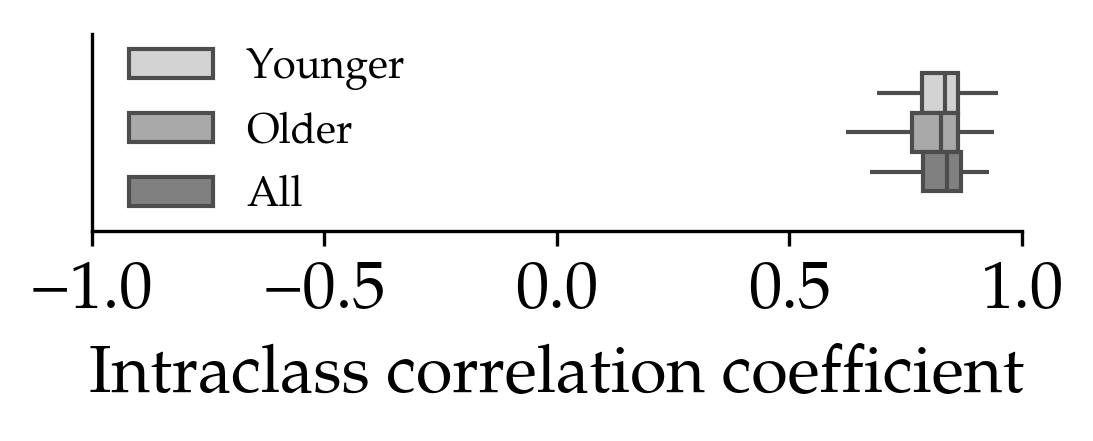

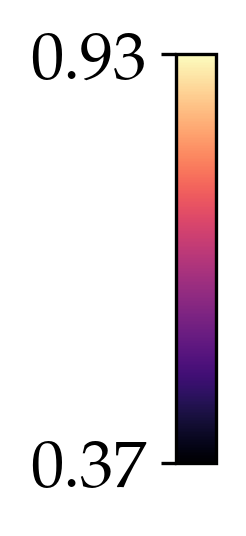

In [31]:
icc_seed_by_age_median = pd.DataFrame({k: v.median(axis=1) for k, v in icc_seed_by_age.items()})
icc_seed_by_age_median['all'] = icc_seed_median
print(icc_seed_by_age_median.describe().round(3))
plot.plot_icc_by_age(icc_seed_by_age_median, 'schaefer-100')